In [1]:
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Load training and validation data
train_data = ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [6]:
val_data = ImageFolder(root=val_dir, transform=transform)
valloader = DataLoader(val_data, batch_size=32, shuffle=False)

In [7]:
# Initialize the ResNet model
model = models.resnet101(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
number_of_epochs = 30

In [10]:
# Initialize a dictionary to store metrics
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': []
}

In [11]:
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / total_train
    epoch_train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_accuracy'].append(epoch_train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            
            val_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / total_val
    val_accuracy = accuracy_score(val_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='macro')
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_precision'].append(val_precision)

    print(f'Epoch {epoch + 1}/{number_of_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_accuracy:.2f}%, Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Validation Precision: {val_precision:.4f}')

Epoch 1/30
Train Loss: 0.6712, Accuracy: 56.70%, Loss: 0.7217, Val Accuracy: 0.54%, Validation Precision: 0.4826


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30
Train Loss: 0.6942, Accuracy: 51.03%, Loss: 0.9629, Val Accuracy: 0.43%, Validation Precision: 0.2143
Epoch 3/30
Train Loss: 0.6777, Accuracy: 58.76%, Loss: 0.6912, Val Accuracy: 0.61%, Validation Precision: 0.6283
Epoch 4/30
Train Loss: 0.6371, Accuracy: 60.31%, Loss: 0.6216, Val Accuracy: 0.79%, Validation Precision: 0.7889


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30
Train Loss: 0.3946, Accuracy: 78.87%, Loss: 1.5431, Val Accuracy: 0.43%, Validation Precision: 0.2143
Epoch 6/30
Train Loss: 0.2208, Accuracy: 93.81%, Loss: 0.7377, Val Accuracy: 0.57%, Validation Precision: 0.5455
Epoch 7/30
Train Loss: 0.1714, Accuracy: 97.42%, Loss: 0.9622, Val Accuracy: 0.64%, Validation Precision: 0.7125


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/30
Train Loss: 0.1110, Accuracy: 97.42%, Loss: 2.3292, Val Accuracy: 0.43%, Validation Precision: 0.2143
Epoch 9/30
Train Loss: 0.1432, Accuracy: 94.85%, Loss: 1.1393, Val Accuracy: 0.57%, Validation Precision: 0.7500
Epoch 10/30
Train Loss: 0.0387, Accuracy: 100.00%, Loss: 0.6785, Val Accuracy: 0.68%, Validation Precision: 0.7339
Epoch 11/30
Train Loss: 0.0852, Accuracy: 98.45%, Loss: 1.0241, Val Accuracy: 0.61%, Validation Precision: 0.6905
Epoch 12/30
Train Loss: 0.1457, Accuracy: 95.36%, Loss: 1.3117, Val Accuracy: 0.57%, Validation Precision: 0.6667
Epoch 13/30
Train Loss: 0.0685, Accuracy: 97.94%, Loss: 1.1761, Val Accuracy: 0.64%, Validation Precision: 0.7125
Epoch 14/30
Train Loss: 0.0646, Accuracy: 98.97%, Loss: 0.7764, Val Accuracy: 0.61%, Validation Precision: 0.6128
Epoch 15/30
Train Loss: 0.2426, Accuracy: 89.69%, Loss: 0.6611, Val Accuracy: 0.61%, Validation Precision: 0.6905


/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/30
Train Loss: 0.4233, Accuracy: 80.41%, Loss: 1.8746, Val Accuracy: 0.43%, Validation Precision: 0.2143
Epoch 17/30
Train Loss: 0.4263, Accuracy: 84.54%, Loss: 0.6562, Val Accuracy: 0.68%, Validation Precision: 0.7857
Epoch 18/30
Train Loss: 0.2601, Accuracy: 89.69%, Loss: 0.5780, Val Accuracy: 0.71%, Validation Precision: 0.7143
Epoch 19/30
Train Loss: 0.3494, Accuracy: 89.69%, Loss: 0.6928, Val Accuracy: 0.68%, Validation Precision: 0.7339
Epoch 20/30
Train Loss: 0.1815, Accuracy: 95.36%, Loss: 2.4087, Val Accuracy: 0.46%, Validation Precision: 0.7222
Epoch 21/30
Train Loss: 0.0866, Accuracy: 96.39%, Loss: 1.2688, Val Accuracy: 0.71%, Validation Precision: 0.8000
Epoch 22/30
Train Loss: 0.0236, Accuracy: 100.00%, Loss: 1.1819, Val Accuracy: 0.82%, Validation Precision: 0.8529
Epoch 23/30
Train Loss: 0.0159, Accuracy: 100.00%, Loss: 1.1180, Val Accuracy: 0.79%, Validation Precision: 0.8021
Epoch 24/30
Train Loss: 0.0806, Accuracy: 98.45%, Loss: 1.4741, Val Accuracy: 0.64%, V

In [12]:
file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'

In [13]:
torch.save(model.state_dict(), file_name)

In [14]:
# Function to load the model
def load_model(file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'):
    model = models.resnet101(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(file_name))
    model.to(device)
    model.eval()
    return model

In [15]:
from PIL import Image

# Function to preprocess and predict a new image
def predict_image(model, image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = train_data.classes[predicted[0]]
        
    return predicted_class

In [16]:
image_1 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_1.jpg"
image_2 = test_dir + "/poisonous/Amanita_excelsa/Amanita_excelsa_1.jpg"
image_3 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_2.jpg"

In [17]:
# Example usage
print(f'The imag_1 is predicted as class: {predict_image(load_model(), image_1)}')
print(f'The imag_2 is predicted as class: {predict_image(load_model(), image_2)}')
print(f'The imag_3 is predicted as class: {predict_image(load_model(), image_3)}')

/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The imag_1 is predicted as class: edible
The imag_2 is predicted as class: edible
The imag_3 is predicted as class: edible


## Results

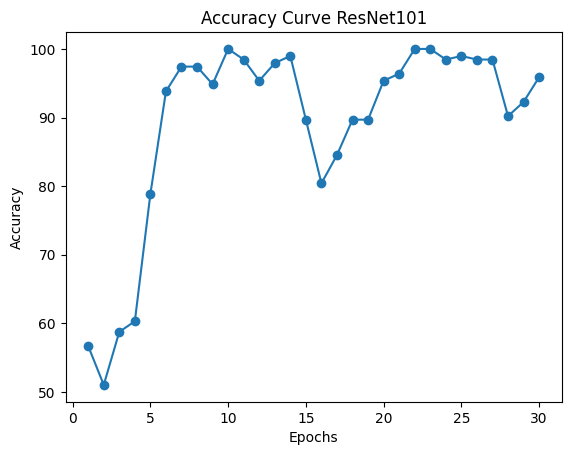

In [18]:
# Plot training & validation accuracy values
acc = history['train_accuracy']
val_acc = history['val_accuracy']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting the accuracy curve
plt.plot(epochs, acc, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve ResNet101')
plt.show()

In [19]:
def evaluate_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    classes = train_data.classes

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if len(all_labels) == 0:
        print("No data was loaded. Check your dataset and DataLoader.")
    else:
        # Calculate and print the confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        # Plotting the confusion matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(
            cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix Resnet101')
        plt.show()

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        
        print('\n--------------------------------\n')
        print("Classification Report Resnet101:")
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Create a DataFrame to display the results in tabular format
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Score': [accuracy, precision, recall, f1]
        })

        # Display the DataFrame
        print(metrics_df.to_string(index=False))

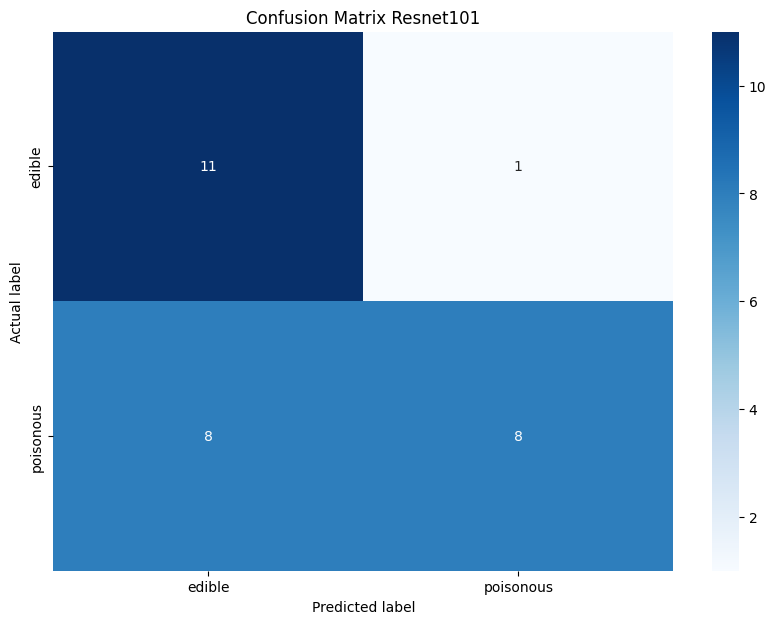

Validation Accuracy: 67.86%

--------------------------------

Classification Report Resnet101:
   Metric    Score
 Accuracy 0.678571
Precision 0.756057
   Recall 0.678571
 F1 Score 0.669862


In [21]:
evaluate_model(model)